# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from collections import Counter

import model_arch
import helper_funcs
import importlib
from model_arch import CategoricalScoreDiffusion
from helper_funcs import generate_sequences
importlib.reload(model_arch)
importlib.reload(helper_funcs)


<module 'helper_funcs' from '/mnt/mnemo9/mpelus/matlas/cdcd_multi_train/cdcd_hmp/helper_funcs.py'>

# Load Data

In [2]:
# Load data
loaded_df = pd.read_hdf('./data/sample_otu_arrays.h5', key='df')
# Set random seed
np.random.seed(42)
# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)
# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
   def __init__(self, df):
       self.df = df
       
       # Find max sequence length for padding
       self.max_len = max(len(x) for x in df['otu_arrays'])
       
   def __len__(self):
       return len(self.df)
   
   def __getitem__(self, idx):
       # Get array for this sample
       array = self.df.iloc[idx]['otu_arrays']
       
       # Create padded tensor
       padded = torch.zeros(self.max_len, dtype=torch.long)
       padded[:len(array)] = torch.tensor(array)
       
       # Create mask (False where we have real tokens, True for padding)
       mask = torch.zeros(self.max_len, dtype=torch.bool)
       mask[len(array):] = True
       
       return padded, mask

# Create datasets
train_dataset = OTUDataset(train_df)
test_dataset = OTUDataset(test_df)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for tokens, mask in train_loader:
   print(f"Batch tokens shape: {tokens.shape}")
   print(f"Batch mask shape: {mask.shape}")

   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

Batch tokens shape: torch.Size([8, 277])
Batch mask shape: torch.Size([8, 277])

Vocabulary size: 519


# Load Model

In [3]:
# Initialize model with the same parameters you showed
embed_dim = 96
num_layers = 4
num_heads = 12
dim_feedforward = 28
num_fourier_features = 4

model = CategoricalScoreDiffusion(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    num_fourier_features=num_fourier_features
)



checkpoint = torch.load("best_model_3.78.pt")

model.load_state_dict(checkpoint['model_state_dict']) #['model_state_dict']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Move model to device
model = model.to(device)

/tmp/ipykernel_688993/1919691523.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_3.78.pt")


# Function

In [195]:
def generate_sequences_with_fixed(model, input_sequences, device='cuda', num_steps=100, temperature=0, seed=42):
    #torch.manual_seed(seed)
    model.eval()
    model = model.to(device)
    
    if isinstance(input_sequences, (list, np.ndarray)):
        input_sequences = torch.tensor(input_sequences, device=device, dtype=torch.long)
    if input_sequences.dim() == 1:
        input_sequences = input_sequences.unsqueeze(0)
        
    num_sequences = input_sequences.shape[0]
    max_sampled_length = input_sequences.shape[1]
    sampled_lengths = torch.full((num_sequences,), max_sampled_length, device=device)
    
    with torch.no_grad():
        uniform_steps = torch.linspace(1, 0, num_steps).to(device)
        timesteps = model.time_warping.warp_time(uniform_steps)
        
        # Initialize exactly as in original
        sigma_T = torch.sqrt(timesteps[0])
        xt = sigma_T * torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
        
        mask = torch.zeros(num_sequences, max_sampled_length, dtype=torch.bool, device=device)
        for i, length in enumerate(sampled_lengths):
            mask[i, length:] = True
            
        diffusion_mask = (input_sequences == 999)
        normalized_weight = model.embedding.get_normalized_weight()
        
        # Store original embeddings for fixed positions
        fixed_embeddings = torch.zeros_like(xt)
        for i in range(num_sequences):
            for j in range(max_sampled_length):
                if not diffusion_mask[i, j]:
                    token_idx = input_sequences[i, j]
                    fixed_embeddings[i, j] = normalized_weight[token_idx]
        
        print("\nRunning diffusion...")
        prev_entropy = None
        for step_idx in tqdm(range(len(timesteps) - 1)):
            t = timesteps[step_idx]
            t_next = timesteps[step_idx + 1]
            
            # Restore fixed positions
            xt = torch.where(diffusion_mask.unsqueeze(-1), xt, fixed_embeddings)
            
            t_batch = t.expand(num_sequences)
            logits = model(xt, mask, t_batch)
            expected_x0 = model.get_expected_embedding(logits)
            
            # Monitor probabilities for 999 position
            probs = F.softmax(logits[diffusion_mask], dim=-1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            top_probs, top_indices = torch.topk(probs, k=3)
            
            print(f"\nStep {step_idx}, t={t:.4f}")
            print(f"Entropy: {entropy[0].item():.4f}")
            print("Top 3 tokens and probabilities:")
            for p, idx in zip(top_probs[0], top_indices[0]):
                print(f"Token {idx.item()}: {p.item():.4f}")
            
            if prev_entropy is not None and entropy > prev_entropy:
                print("WARNING: Entropy increased!")
            prev_entropy = entropy
            
            if t > t_next:
                score = model.calculate_score(xt, expected_x0, t_batch)
                dt = t_next - t
                
                # Print score magnitude for monitoring
                print(f"Score magnitude: {torch.norm(score[diffusion_mask]).item():.4f}")
                
                xt = xt - t * score * dt
                
                sigma = torch.sqrt(t_next)
                noise = torch.randn_like(xt, device=device)
                noise_magnitude = torch.norm(noise[diffusion_mask]).item()
                print(f"Noise magnitude: {noise_magnitude:.4f}")
                
                xt = xt + sigma * noise
        
        final_logits = model(xt, mask, torch.zeros(num_sequences, device=device))
        final_tokens = input_sequences.clone()
        
        if temperature == 0:
            final_tokens[diffusion_mask] = torch.argmax(final_logits[diffusion_mask], dim=-1)
        else:
            probs = F.softmax(final_logits[diffusion_mask] / temperature, dim=-1)
            top_probs, top_indices = torch.topk(probs, k=5)
            print("\nFinal top 5 token probabilities:")
            probs_list = top_probs[0].cpu().numpy()
            indices_list = top_indices[0].cpu().numpy()
            for prob, idx in zip(probs_list, indices_list):
                print(f"Token {idx}: {prob:.4f}")
            final_tokens[diffusion_mask] = torch.multinomial(probs, 1).squeeze(-1)
        
        return final_tokens.cpu().numpy()

In [284]:
# For inpainting existing sequence
sequence = [999,     68, 104, 111, 176, 180, 184, 201, 215, 219, 221,
         223, 225, 228, 257, 266, 277] #12, 14, 18, 45


result_tokens,= generate_sequences_with_fixed(model, input_sequences=sequence, num_steps=2, temperature = 1)

result_tokens


Running diffusion...


100%|██████████| 1/1 [00:00<00:00, 254.63it/s]


Step 0, t=1.0000
Entropy: 3.7540
Top 3 tokens and probabilities:
Token 111: 0.0824
Token 18: 0.0641
Token 176: 0.0570
Score magnitude: 9.6369
Noise magnitude: 10.2481

Final top 5 token probabilities:
Token 184: 0.1759
Token 111: 0.1498
Token 221: 0.0637
Token 173: 0.0599
Token 277: 0.0594


array([111,  68, 104, 111, 176, 180, 184, 201, 215, 219, 221, 223, 225,
       228, 257, 266, 277])


Running diffusion...


100%|██████████| 9/9 [00:00<00:00, 320.49it/s]


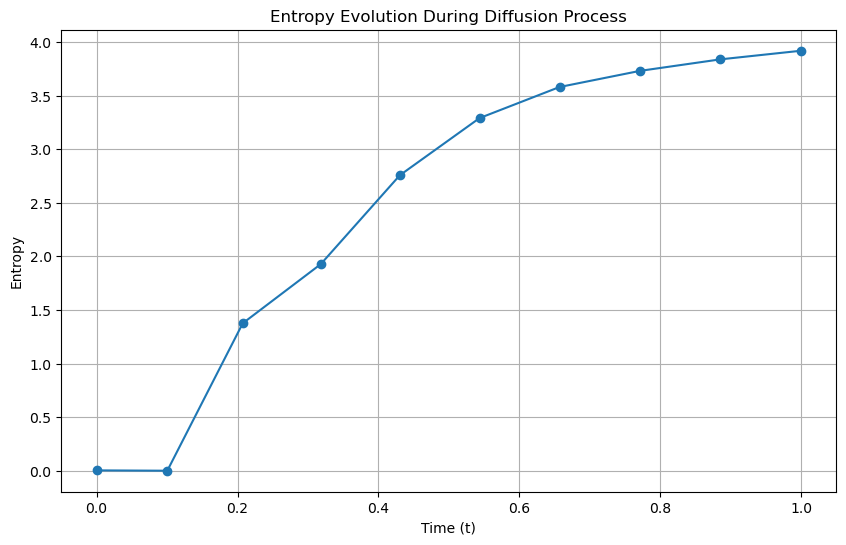

In [427]:
import matplotlib.pyplot as plt
def generate_sequences_with_fixed(model, input_sequences, device='cuda', num_steps=100, temperature=0):
    model.eval()
    model = model.to(device)
    
    if isinstance(input_sequences, (list, np.ndarray)):
        input_sequences = torch.tensor(input_sequences, device=device, dtype=torch.long)
    if input_sequences.dim() == 1:
        input_sequences = input_sequences.unsqueeze(0)
        
    num_sequences = input_sequences.shape[0]
    max_sampled_length = input_sequences.shape[1]
    sampled_lengths = torch.full((num_sequences,), max_sampled_length, device=device)
    
    # List to store entropy values
    entropy_values = []
    t_values = []
    
    with torch.no_grad():
        uniform_steps = torch.linspace(1, 0, num_steps).to(device)
        timesteps = model.time_warping.warp_time(uniform_steps)
        
        sigma_T = torch.sqrt(timesteps[0])
        xt = sigma_T * torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
        
        mask = torch.zeros(num_sequences, max_sampled_length, dtype=torch.bool, device=device)
        for i, length in enumerate(sampled_lengths):
            mask[i, length:] = True
            
        diffusion_mask = (input_sequences == 999)
        normalized_weight = model.embedding.get_normalized_weight()
        
        fixed_embeddings = torch.zeros_like(xt)
        for i in range(num_sequences):
            for j in range(max_sampled_length):
                if not diffusion_mask[i, j]:
                    token_idx = input_sequences[i, j]
                    fixed_embeddings[i, j] = normalized_weight[token_idx]
        
        print("\nRunning diffusion...")
        for step_idx in tqdm(range(len(timesteps) - 1)):
            t = timesteps[step_idx]
            t_next = timesteps[step_idx + 1]
            
            xt = torch.where(diffusion_mask.unsqueeze(-1), xt, fixed_embeddings)
            
            t_batch = t.expand(num_sequences)
            logits = model(xt, mask, t_batch)
            expected_x0 = model.get_expected_embedding(logits)
            
            probs = F.softmax(logits[diffusion_mask], dim=-1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            
            # Store values
            entropy_values.append(entropy[0].item())
            t_values.append(t.item())
            
            if t > t_next:
                score = model.calculate_score(xt, expected_x0, t_batch)
                dt = t_next - t
                xt = xt -  score * dt # debate if there should be a time term here.
                sigma = torch.sqrt(t_next) * 0 #regular ode does not have this noise term
                noise = torch.randn_like(xt, device=device)
                xt = xt +  t_next * sigma * noise
        
        # Store final values
        final_logits = model(xt, mask, torch.zeros(num_sequences, device=device))
        final_probs = F.softmax(final_logits[diffusion_mask], dim=-1)
        final_entropy = -torch.sum(final_probs * torch.log(final_probs + 1e-10), dim=-1)
        entropy_values.append(final_entropy[0].item())
        t_values.append(0.0)
        
        final_tokens = input_sequences.clone()
        
        if temperature == 0:
            final_tokens[diffusion_mask] = torch.argmax(final_logits[diffusion_mask], dim=-1)
        else:
            probs = F.softmax(final_logits[diffusion_mask] / temperature, dim=-1)
            final_tokens[diffusion_mask] = torch.multinomial(probs, 1).squeeze(-1)
        
        return final_tokens.cpu().numpy(), entropy_values, t_values

# Plot the results
def plot_entropy_evolution(entropy_values, t_values):
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, entropy_values, '-o')
    plt.xlabel('Time (t)')
    plt.ylabel('Entropy')
    plt.title('Entropy Evolution During Diffusion Process')
    plt.grid(True)
    return plt

# Usage example:
sequence = [12, 14, 18, 45, 68, 104, 111, 176, 180, 184, 201, 215, 219, 221, 223, 225, 228, 257, 266, 277, 999]
result_tokens, entropy_values, t_values = generate_sequences_with_fixed(model, sequence, num_steps=10)
plot_entropy_evolution(entropy_values, t_values)
plt.show()